In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def import_and_clean_file(file, file_dir):
    # read data from name of file
    sensor, student, activity, activity_subtype, _, date, timestamp = file[:-4].split("_")
    # read in database
    df = pd.read_csv(file_dir)
    # drop features we dont want
    df = df.drop(['ind', 'mag_x','mag_y','mag_z', 'gyro_x', 'gyro_y', 'gyro_z'], axis = 1, errors = 'ignore')
    df['timestamp'] = df['timestamp'].astype(np.float64)
    df['activity'] = activity
    df['activity_subtype'] = activity_subtype
    df.sort_values(by=['timestamp'])
    
    return df

In [3]:
def get_X_y(directory='2023', window_size=50, overlap=10):
    # Initialize lists to store data and labels
    X = []  # Data
    y = []  # Labels

    # Loop through the clean-named subfolders
    for student in os.listdir(directory):
            if "placeholder" not in student:
                student_directory = os.path.join(directory, student)
                # itterate through students data
                for file in os.listdir(student_directory):
                    file_dir = os.path.join(student_directory, file)
                    if os.path.isfile(file_dir) and "clean" in file and "Respeck" in file:
                        sensor, student, activity, activity_subtype, _, date, timestamp = file[:-4].split("_")
                        df = import_and_clean_file(file, file_dir)
                        # Split the time series data into overlapping windows
                        for i in range(0, len(df) - window_size + 1, overlap):
                            window = df.copy()[i:i + window_size]
                            # create X matrix
                            X.append(window.drop(columns=['timestamp','activity', 'activity_subtype']))
                            # create y matrix
                            y.append(activity)

    return np.array(X), np.array(y).reshape(-1,1)

In [18]:
X, y = get_X_y('2023', 25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)

pd.DataFrame(X_train[0]).head()

(7819, 25, 3) (7819, 1)


,0,1,2
0,-0.205078,-0.983704,-0.051819
1,-0.095947,-0.868225,-0.212463
2,-0.115967,-0.993469,-0.060364
3,-0.166260,-0.947571,-0.145081
4,-0.369141,-1.045959,0.051208


In [19]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [24]:
def evaluate_1d_cnn(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 20, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=6, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    keras.layers.MaxPooling3D
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='leaky_relu'))
    model.add(keras.layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1, shuffle=False)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return history, accuracy, model

In [32]:
def evaluate_2d_cnn(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 20, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=64, kernel_size=6, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=6, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    keras.layers.MaxPooling3D
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='leaky_relu'))
    model.add(keras.layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1, shuffle=False)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return history, accuracy, model

In [33]:
history, accuracy, model = evaluate_2d_cnn(X_train, y_train, X_test, y_test)
print(accuracy)

(7819, 25, 3)


ValueError: Input 0 of layer "conv2d_2" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 25, 3)

In [14]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/6q/yjm90tjx6td5_1v23jrh5nyc0000gn/T/tmpgwj7sxq3/assets


INFO:tensorflow:Assets written to: /var/folders/6q/yjm90tjx6td5_1v23jrh5nyc0000gn/T/tmpgwj7sxq3/assets
2023-10-11 11:26:42.448246: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-10-11 11:26:42.448270: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-10-11 11:26:42.448545: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/6q/yjm90tjx6td5_1v23jrh5nyc0000gn/T/tmpgwj7sxq3
2023-10-11 11:26:42.449531: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-10-11 11:26:42.449536: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/6q/yjm90tjx6td5_1v23jrh5nyc0000gn/T/tmpgwj7sxq3
2023-10-11 11:26:42.451464: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-10-11 11:26:42.452560: I tensorflow/cc/saved_model/load

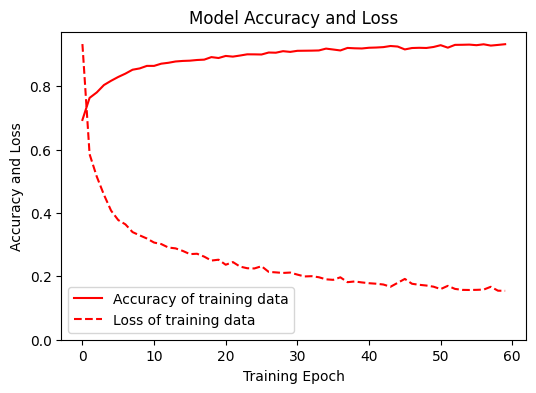

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [73]:
interpreter = tf.lite.Interpreter('/Users/danielkim/Desktop/pdiotapp-master/app/src/main/assets/model.tflite')
interpreter.get_input_details()

[{'name': 'serving_default_conv1d_6_input:0',
  'index': 0,
  'shape': array([ 1, 25,  7], dtype=int32),
  'shape_signature': array([-1, 25,  7], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test_pred, predictions))